<a href="https://colab.research.google.com/github/BYU-Handwriting-Lab/GettingStarted/blob/egb/notebooks/named-entity-recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Named-Entity-Recognition in TensorFlow 2

This notebook contains code to do Named Entity Reconition in TensorFlow 2.

## Imports and Dependencies

TensorFlow Addons apparently has an implementation of CRF that is compatible with TF2 and tf.keras.

In [1]:
# Used in Colab to say we're using Version 2
try:
  %tensorflow_version 2.x
except Exception:
  pass

In [4]:
!pip install tf2crf

In [ ]:
!pip install bert-for-tf2

In [2]:
# TensorFlow
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_addons as tfa
import tensorflow.keras as K
import tensorflow.keras.layers as L
from tensorflow.keras.regularizers import l2

# Python
import os
import string

# Data Structures
import numpy as np
import pandas as pd
import json

# Image/Plotting
from matplotlib import pyplot as plt
from sklearn import metrics
import seaborn as sns

# Debugging
from tqdm import tqdm
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode='Plain', color_scheme='LightBg', tb_offset=1) # Change to 'Verbose' mode for additional debugging

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# Insert file path to Esposalles Dataset in your Google Drive
# Note that '!' indicates a shell command rather than python code...

!wget -q https://raw.githubusercontent.com/ericburdett/named-entity-recognition/master/char_set.json
!wget -q https://raw.githubusercontent.com/ericburdett/named-entity-recognition/master/esposalles-labels.csv

In [4]:
# ID: 1T2QLKZJ9E392vsbaHuXcdTvAhpbXLWtm
!wget -q --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1T2QLKZJ9E392vsbaHuXcdTvAhpbXLWtm' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1T2QLKZJ9E392vsbaHuXcdTvAhpbXLWtm" -O french_ner_dataset.csv && rm -rf /tmp/cookies.txt

In [6]:
!ls -l

total 2188
-rw-r--r-- 1 root root    5212 Jul 23 15:38 char_set.json
-rw-r--r-- 1 root root    5212 Jul 23 15:38 char_set.json.1
-rw-r--r-- 1 root root 1773710 Jul 23 15:38 esposalles-labels.csv
-rw-r--r-- 1 root root  442182 Jul 23 15:38 french_ner_dataset.csv
drwxr-xr-x 1 root root    4096 Jul 10 16:29 sample_data


## Encoding Class

The encoding class helps us map between strings and indexes.

In [5]:
class Encoder():
  def __init__(self, entity_list, sequence_size=20):
    self.entity_dict = {e: i for i, e in enumerate(entity_list)}
    self.idx_entity_dict = {v: k for k, v in self.entity_dict.items()}
    self.sequence_size = sequence_size

    with open('char_set.json') as file:
      self.char_dict = json.load(file)
    
  def char_to_idx(self, char):
    if char in self.char_dict['char_to_idx']:
      return int(self.char_dict['char_to_idx'][char])
    else:
      return 0
  
  def idx_to_char(self, idx):
    if str(int(idx)) in self.char_dict['idx_to_char']:
      return self.char_dict['idx_to_char'][str(int(idx))]
    else:
      return ''
  
  def str_to_idxs(self, string):
    assert type(string) == str

    zeros = np.zeros(self.sequence_size)
    idxs = []
    for char in string:
      idxs.append(self.char_to_idx(char))
    
    idxs = np.concatenate((idxs, zeros))[:self.sequence_size]

    return idxs

  def str_to_idxs_batch(self, batch):
    idxs = []
    for string in batch:
      print('type:', type(string))
      print('value:', string)
      idxs.append(self.str_to_idxs(string))
    return idxs
  
  def idxs_to_str(self, idxs):
    chars = ''

    for idx in idxs:
      chars += self.idx_to_char(idx)
    
    return chars
  
  def idxs_to_str_batch(self, batch):
    strings = []
    for idxs in batch:
      strings.append(self.idxs_to_str(idxs))
    return strings
  
  def entity_to_idx(self, entity):
    return self.entity_dict[entity]
  
  def entity_to_idxs(self, entities):
    idxs = []
    for entity in entities:
      idxs.append(self.entity_to_idx(entity))
    return idxs
  
  def idx_to_entity(self, idx):
    return self.idx_entity_dict[idx]

  def num_classes(self):
    return len(self.entity_dict)

## Generator Creation

TensorFlow can use a Python Generator to access the dataset during training

In [6]:
# TensorFlow uses Generators to access the dataset during training
def esposalles_df(path='/content/esposalles-labels.csv'):
  if not os.path.exists(path):
    raise Exception('Esposalles dataset does not exist in ' + path)
  
  df = pd.read_csv(path, header=None, sep='\t', names=['img', 'entity', 'rel-entity', 'word', 'id'])
  df = df.drop(columns=['img'])

  return df

def dataset_df(path='/content/french_ner_dataset.csv'):
  if not os.path.exists(path):
    raise Exception('French dataset does not exist in ' + path)
  
  df = pd.read_csv(path, header=None, sep='\t', names=['word', 'entity', 'id'])

  df.loc[df['entity'] == 'DeathCity', 'entity'] = 'DeathPlace'
  df.loc[df['entity'] == 'DeathCounty', 'entity'] = 'DeathPlace'
  df.loc[df['entity'] == 'DeathCountry', 'entity'] = 'DeathPlace'
  df.loc[df['entity'] == 'DeathState', 'entity'] = 'DeathPlace'

  df.loc[df['entity'] == 'DeathDay', 'entity'] = 'DeathDate'
  df.loc[df['entity'] == 'DeathMonth', 'entity'] = 'DeathDate'
  df.loc[df['entity'] == 'DeathYear', 'entity'] = 'DeathDate'

  df.loc[df['entity'] == 'BirthCity', 'entity'] = 'none'
  df.loc[df['entity'] == 'BirthState', 'entity'] = 'none'
  df.loc[df['entity'] == 'BirthCounty', 'entity'] = 'none'

  df.loc[df['entity'] == 'GivenName', 'entity'] = 'Name'
  df.loc[df['entity'] == 'Surname', 'entity'] = 'Name'

  df.loc[df['entity'] == 'MotherGivenName', 'entity'] = 'RelativeName'
  df.loc[df['entity'] == 'MotherSurname', 'entity'] = 'RelativeName'
  df.loc[df['entity'] == 'FatherGivenName', 'entity'] = 'RelativeName'
  df.loc[df['entity'] == 'FatherSurname', 'entity'] = 'RelativeName'
  df.loc[df['entity'] == 'SpouseGivenName', 'entity'] = 'RelativeName'
  df.loc[df['entity'] == 'SpouseSurname', 'entity'] = 'RelativeName'

  # df.loc[df['entity'] == 'Start', 'entity'] = 'none'

  return df

def encode_word_label(data, entity_type, encoder):
  word = data['word']
  encoded_word = encoder.str_to_idxs(str(word))
  label = data[entity_type]
  encoded_label = encoder.entity_to_idx(label)

  return (encoded_word, encoded_label)

def entity_list_from_df(df, value='entity'):
  return list(set(df[value].values))

def single_word_generator(dataset='french'):
  df = dataset_df()

def dataset_generator(dataset='french', entity_type='entity'): # options include 'entity' and 'rel-entity'
  if dataset == 'french':
    data = dataset_df()
    df_size = data['id'].max()
    range_var = range(1, df_size + 1)
  else:
    data = esposalles_df()
    df_size = data['id'].max() + 1
    range_var = range(df_size)

  entity_list = entity_list_from_df(data)
  encoder = Encoder(entity_list)

  for i in range_var:
    ith_sentence_words = data.loc[data['id'] == i]

    sentence_words = []
    sentence_labels = []

    for index, row in ith_sentence_words.iterrows():
      encoded_word = encoder.str_to_idxs(str(row['word']))
      encoded_label = encoder.entity_to_idx(row['entity'])

      sentence_words.append(encoded_word)
      sentence_labels.append(encoded_label)
    
    yield tf.constant(np.array(sentence_words), dtype=tf.int64), tf.constant(np.array(sentence_labels), dtype=tf.int32)

In [8]:
dataset_df().drop(columns=['id']).drop_duplicates().groupby(['entity']).agg(['count'])

,word
,count
entity,
DeathAge,102
DeathDate,107
DeathPlace,75
Name,406
RelativeName,409
none,2538


In [22]:
arr = np.repeat(np.arange(10), 4)
print(arr)
np.random.shuffle(arr)
print(arr)

[0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3 4 4 4 4 5 5 5 5 6 6 6 6 7 7 7 7 8 8 8 8 9
 9 9 9]
[2 4 8 0 9 8 2 9 1 5 6 6 4 2 7 1 0 8 6 7 2 3 6 7 9 0 8 4 7 5 4 5 3 0 3 1 3
 5 9 1]


In [28]:
np.random.choice(10, 50)

array([1, 6, 2, 3, 7, 6, 2, 8, 3, 1, 9, 8, 4, 9, 9, 9, 4, 7, 0, 3, 6, 8,
       2, 8, 1, 6, 6, 2, 3, 8, 0, 0, 7, 4, 8, 9, 8, 1, 7, 0, 2, 9, 3, 5,
       6, 1, 0, 0, 8, 8])

In [ ]:
np.concatenate()

In [35]:
df = dataset_df().drop(columns=['id']).drop_duplicates()
nones = df.loc[df['entity'] == 'none'].to_numpy()
np.concatenate((nones[[0, 2, 3]], nones[[1, 4, 5]]))

array([['Du', 'none'],
       ['de', 'none'],
       ['deces', 'none'],
       ['acte', 'none'],
       ['franÃ§ois', 'none'],
       ['gichet', 'none']], dtype=object)

In [75]:
def balanced_generator(size=1000, train=True):

  df = dataset_df()
  encoder = Encoder(entity_list_from_df(df))

  num_column_samples = size // 7

  df = df.drop(columns=['id']).drop_duplicates()
  nones = df.loc[df['entity'] == 'none'].to_numpy()
  starts = df.loc[df['entity'] == 'Start'].to_numpy()
  names = df.loc[df['entity'] == 'Name'].to_numpy()
  death_dates = df.loc[df['entity'] == 'DeathDate'].to_numpy()
  death_places = df.loc[df['entity'] == 'DeathPlace'].to_numpy()
  death_ages = df.loc[df['entity'] == 'DeathAge'].to_numpy()
  relative_names = df.loc[df['entity'] == 'RelativeName'].to_numpy()

  nones_order = np.random.choice(len(nones), num_column_samples).tolist()
  starts_order = np.random.choice(len(starts), num_column_samples).tolist()
  names_order = np.random.choice(len(names), num_column_samples).tolist()
  death_dates_order = np.random.choice(len(death_dates), num_column_samples).tolist()
  death_places_order = np.random.choice(len(death_places), num_column_samples).tolist()
  death_ages_order = np.random.choice(len(death_ages), num_column_samples).tolist()
  relative_names_order = np.random.choice(len(relative_names), num_column_samples).tolist()

  all = np.concatenate((nones[nones_order], names[names_order], death_dates[death_dates_order],
                        death_places[death_places_order], death_ages[death_ages_order],
                        relative_names[relative_names_order], starts[starts_order]))
  np.random.shuffle(all)

  for word, label in all:
    yield tf.constant(encoder.str_to_idxs(word), dtype=tf.int32), tf.constant(encoder.entity_to_idx(label), dtype=tf.int32)

In [106]:
dataset = tf.data.Dataset.from_generator(lambda: balanced_generator(size=2100, train=True),
                                         (tf.int32, tf.int32),
                                         (tf.TensorShape([20]), tf.TensorShape([])))

In [107]:
for word, label in dataset:
  print(word, label)

tf.Tensor([82 69 74 67 80 69 65 73 65  0  0  0  0  0  0  0  0  0  0  0], shape=(20,), dtype=int32) tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor([33 61 64 75 80  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0], shape=(20,), dtype=int32) tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor([21 65 73 65  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0], shape=(20,), dtype=int32) tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor([72 72 61 81 73 65  0  0  0  0  0  0  0  0  0  0  0  0  0  0], shape=(20,), dtype=int32) tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor([79 69 74 77 61 74 80 65  0  0  0  0  0  0  0  0  0  0  0  0], shape=(20,), dtype=int32) tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor([79 65 63  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0], shape=(20,), dtype=int32) tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor([61 73 76 69 81 79  0  0  0  0  0  0  0  0  0  0  0  0  0  0], shape=(20,), dtype=int32) tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor([19 61 74 79  0  0  0  0  0  0  0  0  0  0  0

In [142]:
def augment(sentence, labels):
  sentence = sentence.numpy()
  labels = labels.numpy()

  encoder = Encoder(entity_list_from_df(dataset_df()))

  new_sentences = [sentence]
  new_labels = [labels]
  for i in range(sentence.shape[0]):
    if encoder.idx_to_entity(labels[i]) != 'none':
      start = i - 5
      if start < 0:
        start = 0
      end = i + 5
      if end >= len(labels):
        end = len(labels) - 1
      
      new_sentences.append(sentence[start:end])
      new_labels.append(labels[start:end])
  
  print(new_sentences)

  
  return tf.data.Dataset.from_tensor_slices((new_sentences, new_labels))

In [176]:
def trim_nones(sentence, labels):
  should_augment = tf.random.uniform((), maxval=6, dtype=tf.int32)
  if should_augment == 0:
    return sentence, labels

  sentence = sentence.numpy()
  labels = labels.numpy()

  encoder = Encoder(entity_list_from_df(dataset_df()))

  new_sentence = []
  new_labels = []
  none_count = 0
  for index, (word, label) in enumerate(zip(sentence, labels)):
    if index == 0:
      new_sentence.append(word)
      new_labels.append(label)
    elif encoder.idx_to_entity(label) == 'none':
      none_count += 1
    elif none_count != 0:
      new_sentence.append(sentence[index - 1])
      new_labels.append(encoder.entity_to_idx('none'))
      new_sentence.append(word)
      new_labels.append(label)
    else:
      new_sentence.append(word)
      new_labels.append(label)
  
  return tf.constant(new_sentence, dtype=tf.int64), tf.constant(new_labels, dtype=tf.int32)

In [178]:
new_sentence, new_labels =augment2(sentence, labels)
new_labels

<tf.Tensor: shape=(37,), dtype=int32, numpy=
array([5, 0, 0, 0, 0, 0, 0, 5, 2, 5, 3, 5, 3, 5, 3, 5, 3, 5, 1, 5, 1, 5,
       3, 5, 3, 5, 4, 5, 4, 5, 1, 5, 1, 5, 4, 5, 4], dtype=int32)>

In [155]:
dataset_df().groupby('entity').count()

,word,id
entity,,
DeathAge,423,423
DeathDate,948,948
DeathPlace,565,565
Name,804,804
RelativeName,797,797
none,22690,22690


In [ ]:
encoder = Encoder(entity_list_from_df(dataset_df()))
encoder.idxs_to_str_batch(sentence)

In [146]:
def my_func(sentence, labels):
  print(sentence)
  print(labels)
  return tf.data.Dataset.from_tensor_slices((sentence, labels))

In [147]:
my_func(sentence, labels)

tf.Tensor(
[[34 81  0 ...  0  0  0]
 [64 65 81 ...  0  0  0]
 [40 61 74 ...  0  0  0]
 ...
 [34 75 74 ...  0  0  0]
 [33 68 61 ...  0  0  0]
 [37 65 78 ...  0  0  0]], shape=(109, 20), dtype=int64)
tf.Tensor(
[5 0 0 0 0 0 0 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 2 5 5 5 5 3 3 5 3 3 5 5 5 5
 5 5 5 5 5 5 5 5 1 5 5 1 5 5 5 5 5 5 5 3 3 5 5 5 4 4 5 5 5 5 5 5 5 5 5 5 5
 5 5 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 1 5 5 5 5 5 5 5 5 5 4 4 5 5], shape=(109,), dtype=int32)


<TensorSliceDataset shapes: ((20,), ()), types: (tf.int64, tf.int32)>

In [130]:
gen = dataset_generator()

sentence, labels = next(gen)

sentence

<tf.Tensor: shape=(109, 20), dtype=int64, numpy=
array([[34, 81,  0, ...,  0,  0,  0],
       [64, 65, 81, ...,  0,  0,  0],
       [40, 61, 74, ...,  0,  0,  0],
       ...,
       [34, 75, 74, ...,  0,  0,  0],
       [33, 68, 61, ...,  0,  0,  0],
       [37, 65, 78, ...,  0,  0,  0]])>

## Elmo Embeddings

In [14]:
conv = L.Conv1DTranspose()
tf.expand_dims(sentence, 2)

AttributeError: ignored

In [43]:
class ElmoEmbedding(K.Model):
  def __init__(self, input_dim=197, output_dim=1024, input_length=20):
    super(ElmoEmbedding, self).__init__()

    self.input_length = input_length

    self.embedding = L.Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length)
    self.conv1 = L.Conv1D(output_dim, 3, padding='same', activation='relu')
    self.lstm1 = L.Bidirectional(L.LSTM(output_dim//2, return_sequences=True))
    self.lstm2 = L.Bidirectional(L.LSTM(output_dim//2, return_sequences=True))
  
  def call(self, x, training=False, **kwargs):
    out = self.embedding(x)
    out1 = self.conv1(out)
    lstm1_in = tf.expand_dims(tf.reshape(out, [out.shape[0], out.shape[1] * out.shape[2]]), 0)
    lstm1_out = self.lstm1(lstm1_in)
    out2 = tf.reshape(lstm1_out, out1.shape)
    lstm2_out = self.lstm2(lstm1_in + lstm1_out)
    out3 = tf.reshape(lstm2_out, out1.shape)

    out = out1 + out2 + out3

    print(out.shape)

    return out

In [44]:
class LanguageModel(K.Model):
  def __init__(self, vocab_size=197):
    super(LanguageModel, self).__init__()

    self.embedding = ElmoEmbedding()
    self.dense = L.Dense(vocab_size)

  def call(self, x, training=False, **kwargs):
    out = self.embedding(x)
    out = self.dense(out)

    return out

In [45]:
gen = dataset_generator()
sentence, labels = next(gen)
sentence_in = sentence[:-1]
target = sentence[1:]

lm = LanguageModel()
out = lm(sentence_in)
out.shape

InvalidArgumentError: ignored

In [118]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
loss_fn(target, out)

<tf.Tensor: shape=(), dtype=float32, numpy=11.096893>

### Train the Embedding Model

In [168]:
class Train:
  def __init__(self):
    self.epochs = 100

    df = dataset_df()
    dataset_size = df['id'].max()
    self.train_dataset_size = int(.8 * dataset_size)
    self.val_dataset_size = dataset_size - self.train_dataset_size

    self.dataset = tf.data.Dataset.from_generator(
        lambda: dataset_generator(),
        (tf.int64, tf.int32)
    )
    self.train_dataset = self.dataset.take(self.train_dataset_size)
    self.val_dataset=  self.dataset.skip(self.train_dataset_size)

    self.model = LanguageModel()
    self.loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
    self.optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

    self.train_loss = tf.keras.metrics.Mean(name='train_loss')
    self.val_loss = tf.keras.metrics.Mean(name='val_loss')

  @tf.function(experimental_relax_shapes=True)
  def train_step(self, x, y):
    with tf.GradientTape() as tape:
      predictions = self.model(x, training=True)
      loss = self.loss_fn(y, predictions)
    
    gradients = tape.gradient(loss, self.model.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

    self.train_loss(loss)
  
  @tf.function(experimental_relax_shapes=True)
  def val_step(self, x, y):
    predictions = self.model(y, training=False)
    loss = self.loss_fn(y, predictions)
    self.val_loss(loss)
  
  def __call__(self):
    for epoch in range(self.epochs):
      self.train_loss.reset_states()
      self.val_loss.reset_states()

      # Train Step
      train_loop = tqdm(total=self.train_dataset_size, leave=True, position=0)
      for sentence, _ in self.train_dataset:
        x = sentence[:-1]
        y = sentence[1:]
        self.train_step(x, y)
        train_loop.set_description('Train - Epoch: {}, Loss: {:.4f}'.format(epoch, self.train_loss.result()))
        train_loop.update(1)
      train_loop.close()
      
      # Validation Step
      val_loop = tqdm(total=self.val_dataset_size, position=0, leave=True)
      for sentence, _ in self.val_dataset:
        x = sentence[:-1]
        y = sentence[1:]
        self.val_step(x, y)
        val_loop.set_description('Val   - Epoch: {}, Loss: {:.4f}'.format(epoch, self.val_loss.result()))
        val_loop.update(1)
      val_loop.close()

In [ ]:
train = Train()
train()

## Model Architecture

This is where we can build our model using the tf.keras high-level API

We subclass from tf.keras.Model and implement the *call* method. This is the *forward pass* of the neural network.

In [9]:
class ResidualBlock(K.Model):
  def __init__(self, filters, activation=L.ReLU, dropout_rate=0.2):
    super(ResidualBlock, self).__init__()

    self.filters = filters
    self.act_final = activation()

    self.shortcut = L.Conv2D(filters, kernel_size=(1, 1), use_bias=False)

    self.conv = tf.keras.Sequential()
    self.conv.add(L.Conv2D(filters, kernel_size=(3, 3), padding='same'))
    self.conv.add(L.BatchNormalization(renorm=True))
    self.conv.add(activation())
    if dropout_rate is not None and dropout_rate != 0.0:
      self.conv.add(L.Dropout(dropout_rate))

    self.conv.add(L.Conv2D(filters, kernel_size=(3, 3), padding='same'))
    self.conv.add(L.BatchNormalization(renorm=True))
    self.conv.add(activation())
    if dropout_rate is not None and dropout_rate != 0.0:
      self.conv.add(L.Dropout(dropout_rate))

    self.conv.add(L.Conv2D(filters, kernel_size=(3, 3), padding='same'))
    self.conv.add(L.BatchNormalization(renorm=True))
    self.conv.add(activation())
    if dropout_rate is not None and dropout_rate != 0.0:
      self.conv.add(L.Dropout(dropout_rate))

    self.conv4 = L.Conv2D(filters, kernel_size=(3, 3), padding='same')

  def call(self, x, **kwargs):
    # Add shortcut if necessary
    if x.shape[-1] != self.filters: # Channel Dimension
      x = self.shortcut(x)

    # Send through the conv block 
    out = self.conv(x, **kwargs)

    # Element-Wise Addition
    out = tf.math.add(out, x)

    # Final Activation
    out = self.act_final(out)

    return out

In [10]:
class ConditionalRandomField(K.Model):
  def __init__(self, **kwargs):
    super(ConditionalRandomField, self).__init__(**kwargs)

  def build(self, input_shape):
    output_dim = input_shape[-1]
    self.output_dim = output_dim
    assert(len(input_shape)) == 3
    self.transitions = self.add_weight(
        name="transitions",
        shape=[output_dim, output_dim],
        initializer="glorot_uniform",
        trainable=True
    )

  def call(self, x, training=False, **kwargs):
    self.sequence_lengths = tf.reduce_sum(tf.ones_like(x[:,:,0], dtype='int64'), axis=-1)

    if training == False:
      return self.decode(x)
    else:
      return x

  def decode(self, x):
    out, _ = tfa.text.crf_decode(x, self.transitions, self.sequence_lengths)
    out = tf.one_hot(out, x.shape[-1])

    return out

  def loss(self, y_true, y_pred):
    if len(y_true.shape) == 1:
      y_true = tf.expand_dims(y_true, 0)
    
    if len(y_pred.shape) == 2:
      y_pred = tf.expand_dims(y_pred, 0)

    log_likelihood, self.transitions = tfa.text.crf_log_likelihood(
        y_pred,
        y_true,
        self.sequence_lengths,
        transition_params=self.transitions
    )
    return tf.reduce_mean(-log_likelihood)

  def compute_output_shape(self, input_shape):
    return input_shape[:2] + (self.out_dim,)

  def accuracy(self, y_true, y_pred):
    y_pred, _ = tfa.text.crf_decode(
        y_pred, self.transitions, self.sequence_lengths
    )
    y_true = tf.cast(y_true, dtype=y_pred.dtype)
    is_equal = tf.cast(tf.equal(y_true, y_pred), dtype=tf.float32)
    
    return tf.reduce_mean(is_equal)

In [87]:
class NERModel(K.Model):
  def __init__(self, input_dim=197, num_classes=6, input_length=20):
    super(NERModel, self).__init__()

    self.embedding = L.Embedding(input_dim=input_dim, output_dim=128, input_length=input_length)

    self.conv1 = L.Conv2D(128, 3, padding='same', activation='relu')
    self.conv2 = L.Conv2D(256, 3, padding='same', activation='relu')

    self.lstm = L.Bidirectional(L.LSTM(512, dropout=0.3, return_sequences=True, return_state=True))

    self.fc1 = L.Dense(512, activation='relu')
    self.drop = L.Dropout(0.5)
    self.fc2 = L.Dense(num_classes)

    self.softmax = L.Softmax()
  
  # def loss(self, y_true, y_pred):
    # return self.crf.loss(y_true, y_pred)
  
  # def accuracy(self, y_true, y_pred):
    # return self.crf.accuracy(y_true, y_pred)
  
  # def decode(self, y_pred):
    # return self.crf.decode(y_pred)

  def __call__(self, x, initial_state=None, training=False, **kwargs):
    out = self.embedding(x)  # x1: ids by character

    out = tf.expand_dims(out, 0)

    out = self.conv1(out)
    out = self.conv2(out)
    out = tf.reshape(out, [out.shape[0], out.shape[1], out.shape[2] * out.shape[3]])

    out = self.lstm(out, initial_state=initial_state)
    state = out[1:]
    out = out[0]

    out = self.fc1(out)
    out = self.drop(out)
    out = self.fc2(out)

    out = self.softmax(out)

    return out, state

### Test to make sure the model is doing what we think it is...

The output shape should be (NUM_WORDS_IN_SENTENCE, NUM_CLASSES). Example: (41, 6)

The values along Axis=0 represents a word

The values along Axis=1 represents the probability distribution

In [88]:
model = NERModel(num_classes=7)

generator = dataset_generator(dataset='french')
sentence, labels = next(generator)

print(sentence.shape)
print(labels.shape)

results, _ = model(sentence, training=False)
results = tf.squeeze(results)
print('Shape of output from NER Model: ', results.shape)
print('Predicted classes for the sequence: ', tf.argmax(results, axis=1).numpy())
# print('Loss: ', model.loss(labels, results))
# print('Accuracy: ', model.accuracy(labels, results))

(109, 20)
(109,)
Shape of output from NER Model:  (109, 7)
Predicted classes for the sequence:  [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 2 2 2 2 2 2 2 2 2 2 5 0 2 5
 5 2 5 2 5 5 2 2 2 2 2 2 2 5 5 2 2 2 2 5 5 2 2 2 2 0 2 2 2 2 5 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 2 2 2 0 0 0 0 0]


In [74]:
tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE

'sum_over_batch_size'

In [75]:
# loss_fn = tf.keras.losses.CategoricalCrossentropy()
loss_fn = tfa.losses.SigmoidFocalCrossEntropy(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
loss_fn(tf.one_hot(labels, 7), results)

<tf.Tensor: shape=(), dtype=float32, numpy=0.362736>

## Evaluation Metrics

For named-entity-recognition, we will use Precision, Recall, and F1 for our
metrics. An easy way to do this is using sklearn metrics. We need to define
custom functions so that we can pass the *average* parameter when it's wrapped
in a *tf.py_function*.

In [89]:
def precision_score(y_true, y_pred):
  return metrics.precision_score(y_true, y_pred, average='macro')

def recall_score(y_true, y_pred):
  return metrics.recall_score(y_true, y_pred, average='macro')

def f1_score(y_true, y_pred):
  return metrics.f1_score(y_true, y_pred, average='macro')

## Training Loop

Build our training loop and creating custom train_step and val_step functions.

GradientTape allows us to keep track of the losses and gradients for each pass through the network. Structuring our code this way makes it much easier for debugging purposes and for us to iterate through our design.

Notice the decorator *@tf.function*. This tells TensorFlow to create the computation graph from the python code and allows our model to run much faster. The *experimental_relax_shapes* parameter allows us to pass tensors with various sentence lengths without TensorFlow getting upset at us.

TensorFlow 2 also does some weird things with scope when it constructs the computation graph through a @tf.function annotation. Thus, if we use a more object oriented approach, we can avoid some of the nasty scope issues. See the following articles for more details:
* https://pgaleone.eu/tensorflow/tf.function/2019/03/21/dissecting-tf-function-part-1/
* https://pgaleone.eu/tensorflow/tf.function/2019/04/03/dissecting-tf-function-part-2/


In [99]:
tf.TensorShape([])

TensorShape([])

In [182]:
class Train:
  def __init__(self, epochs=15, model=None):
    # How many times through the training set should we go?
    self.epochs = epochs
    self.batch_size = 128

    df = dataset_df()

    # self.train_dataset_size = 2100
    # self.train_dataset = tf.data.Dataset.from_generator(lambda: balanced_generator(size=2100),
                                                        # (tf.int32, tf.int32)).batch(1)

    # Determine sizes for training and validation sets
    dataset_size = df['id'].max()
    self.train_dataset_size = int(.8 * dataset_size)
    self.val_dataset_size = dataset_size - self.train_dataset_size

    # Break up dataset into training/validation
    dataset = tf.data.Dataset.from_generator(
        lambda: dataset_generator(dataset='french'),
        (tf.int64, tf.int32),
        (tf.TensorShape([None, 20]), tf.TensorShape([None])))
    self.train_dataset = dataset.take(self.train_dataset_size)\
                                .shuffle(self.train_dataset_size, reshuffle_each_iteration=True)\
                                # .map(lambda sentence, labels: tf.py_function(trim_nones, [sentence, labels], [tf.int64, tf.int32]))
                                # .flat_map(lambda x1, x2, entities: tf.data.Dataset.from_tensor_slices((x1, x2, entities)))\
                                # .batch(self.batch_size, drop_remainder=True)
    self.val_dataset = dataset.skip(self.train_dataset_size)\
                              .shuffle(self.val_dataset_size, reshuffle_each_iteration=True)\
                              # .flat_map(lambda x1, x2, entities: tf.data.Dataset.from_tensor_slices((x1, x2, entities)))\
                              # .batch(self.batch_size, drop_remainder=True)

    # self.train_dataset_size = df.loc[df['id'] == self.train_dataset_size].index.max()
    # self.val_dataset_size = len(df) - self.train_dataset_size

    # self.train_dataset_size //= self.batch_size
    # self.val_dataset_size //= self.batch_size

    # Create our model
    if model is not None:
      self.model = model
    else:
      self.model = NERModel(num_classes=7)

    self.state = None

    # Use CrossEntropy for our loss function and Adam for our optimizer
    # self.loss_fn = K.losses.SparseCategoricalCrossentropy(from_logits=False)
    self.loss_fn = K.losses.CategoricalCrossentropy(from_logits=False, label_smoothing=0.2)
    # self.loss_fn = tfa.losses.SigmoidFocalCrossEntropy(from_logits=False, reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
    self.optimizer = K.optimizers.Adam(learning_rate=1e-3)

    # Metrics to track our performance
    # Consider adding metrics like Precision/Recall here...
    self.train_loss = tf.keras.metrics.Mean(name='train_loss')
    self.train_precision = tf.keras.metrics.Mean(name='train_precision')
    self.train_recall = tf.keras.metrics.Mean(name='train_recall')
    self.train_f1 = tf.keras.metrics.Mean(name='train_f1')
    self.val_loss = tf.keras.metrics.Mean(name='val_loss')
    self.val_precision = tf.keras.metrics.Mean(name='val_precision')
    self.val_recall = tf.keras.metrics.Mean(name='val_recall')
    self.val_f1 = tf.keras.metrics.Mean(name='val_f1')

  # @tf.function(experimental_relax_shapes=True)
  def train_step(self, sentence, labels, ones):
    with tf.GradientTape() as tape:
      # Make a prediction, calculate the loss
      predictions, _ = self.model(sentence, training=True, initial_state=self.state)
      predictions = tf.squeeze(predictions, 0)
      # loss = self.model.loss(labels, predictions)
      loss = self.loss_fn(tf.one_hot(tf.cast(labels, tf.int32), 7), predictions)

    # Obtain gradients from GradientTape
    gradients = tape.gradient(loss, self.model.trainable_variables)

    # Propagate loss back through the network and take a step with the optimizer  
    self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

    # Update our metrics
    # results = self.model.decode(predictions)
    results = tf.argmax(predictions, axis=1)
    precision = tf.py_function(precision_score, [labels, results], Tout=[tf.float32])
    recall = tf.py_function(recall_score, [labels, results], Tout=[tf.float32])
    f1 = tf.py_function(f1_score, [labels, results], Tout=[tf.float32])

    self.train_loss(loss)
    self.train_precision(precision)
    self.train_recall(recall)
    self.train_f1(f1)

  # @tf.function(experimental_relax_shapes=True)
  def validation_step(self, sentence, labels, ones):
    # Make a prediction and calculate the loss
    predictions, _ = self.model(sentence, training=False, initial_state=self.state)
    predictions = tf.squeeze(predictions, 0)
    # loss = self.model.loss(labels, predictions)
    loss = self.loss_fn(tf.one_hot(tf.cast(labels, tf.int32), 7), predictions)

    # Update our metrics
    results = tf.argmax(predictions, axis=1)
    precision = tf.py_function(precision_score, [labels, results], Tout=[tf.float32])
    recall = tf.py_function(recall_score, [labels, results], Tout=[tf.float32])
    f1 = tf.py_function(f1_score, [labels, results], Tout=[tf.float32])

    self.val_loss(loss)
    self.val_precision(precision)
    self.val_recall(recall)
    self.val_f1(f1)

  def __call__(self):
    # Variables to keep track of our progress through the entire training process
    # Used below when we create our graphs
    try:
      train_losses, val_losses = [], []
      train_precisions, val_precisions = [], []
      train_recalls, val_recalls = [], []
      train_f1s, val_f1s = [], []

      for epoch in range(self.epochs):
        # Reset Metrics for another epoch
        self.train_loss.reset_states()
        self.train_precision.reset_states()
        self.train_recall.reset_states()
        self.train_f1.reset_states()
        self.val_loss.reset_states()
        self.val_precision.reset_states()
        self.val_recall.reset_states()
        self.val_f1.reset_states()

        # Training Loop
        train_loop = tqdm(total=self.train_dataset_size, position=0, leave=True)
        self.state = None
        for sentence, labels in self.train_dataset:
          # One training iteration
          self.train_step(sentence, labels, tf.ones(labels.shape[0], dtype=tf.int32))
          train_loop.set_description('Train - Epoch: {}, Loss: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}'.format(
              epoch, self.train_loss.result(), self.train_precision.result(), self.train_recall.result(), self.train_f1.result()))
          train_loop.update(1)

        train_loop.close()

        # Validation Loop
        val_loop = tqdm(total=self.val_dataset_size, position=0, leave=True)
        self.state = None
        for sentence, labels in self.val_dataset:
          # One validation iteration
          self.validation_step(sentence, labels, tf.ones(labels.shape[0], dtype=tf.int32))
          val_loop.set_description('Val  - Epoch: {}, Loss: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}'.format(
              epoch, self.val_loss.result(), self.val_precision.result(), self.val_recall.result(), self.val_f1.result()))
          val_loop.update(1)
 
        val_loop.close()

        train_losses.append(self.train_loss.result())
        val_losses.append(self.val_loss.result())

        train_precisions.append(self.train_precision.result())
        val_precisions.append(self.val_precision.result())

        train_recalls.append(self.train_recall.result())
        val_recalls.append(self.val_recall.result())

        train_f1s.append(self.train_f1.result())
        val_f1s.append(self.val_f1.result())
    except:
      __ITB__()
    finally:
      return self.model, (train_losses, val_losses), (train_precisions, val_precisions), (train_recalls, val_recalls), (train_f1s, val_f1s)

In [ ]:
try:
  train = Train(epochs=100, model=model2)
  model2, losses, precisions, recalls, f1s = train()
except:
  __ITB__()

## Dataset Stats

In [9]:
esposalles_df().groupby('entity').count()

,rel-entity,word,id
entity,,,
location,4509,4509,4509
name,4997,4997,4997
occupation,3010,3010,3010
other,15176,15176,15176
state,1142,1142,1142
surname,2667,2667,2667


In [154]:
dataset_df().groupby('entity').count()

,word,id
entity,,
DeathAge,423,423
DeathDate,948,948
DeathPlace,565,565
Name,804,804
RelativeName,797,797
none,22690,22690


In [ ]:
22463 / 26227

In [ ]:
370 / 26227

## Results

Show how our model did throughout the training process.

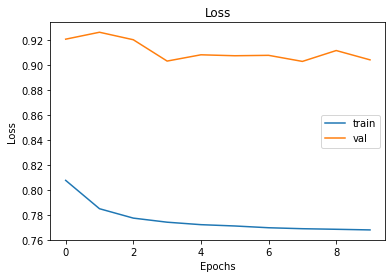

Final Validation Loss: 0.9043


In [184]:
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(losses[0], label='train')
plt.plot(losses[1], label='val')
plt.legend()
plt.show()
print('Final Validation Loss: {:.4f}'.format(losses[1][-1]))

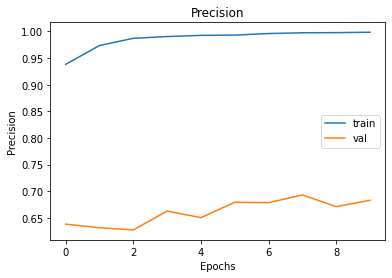

Final Validation Precision: 68.32%


In [185]:
plt.title('Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.plot(precisions[0], label='train')
plt.plot(precisions[1], label='val')
plt.legend()
plt.show()
print('Final Validation Precision: {:.2f}%'.format(precisions[1][-1] * 100))

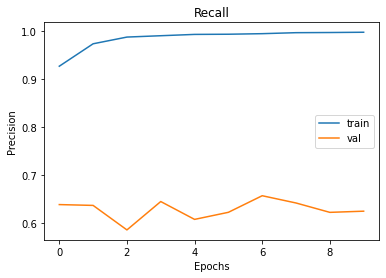

Final Validation Recall: 62.47%


In [186]:
plt.title('Recall')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.plot(recalls[0], label='train')
plt.plot(recalls[1], label='val')
plt.legend()
plt.show()
print('Final Validation Recall: {:.2f}%'.format(recalls[1][-1] * 100))

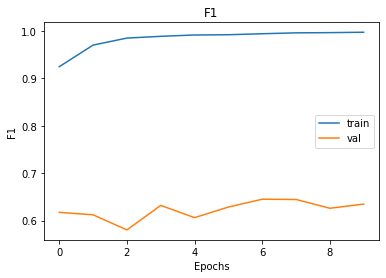

Final Validation F1: 63.48%


In [187]:
plt.title('F1')
plt.xlabel('Epochs')
plt.ylabel('F1')
plt.plot(f1s[0], label='train')
plt.plot(f1s[1], label='val')
plt.legend()
plt.show()
print('Final Validation F1: {:.2f}%'.format(f1s[1][-1] * 100))

## Examples and Confusion Matrix

* Show the final confusion matrix on the validation set.
* Show a couple examples of the model classifying text.

In [189]:
# The number of examples to show how the model did
num_examples = 3

df = dataset_df()
entity_list = list(set(df['entity'].values))
encoder = Encoder(entity_list)

# Determine sizes for training and validation sets
dataset_size = df['id'].max()
train_dataset_size = int(.8 * dataset_size)
val_dataset_size = dataset_size - train_dataset_size

flat_train_dataset_size = df.loc[df['id'] == train_dataset_size].index.max()
flat_val_dataset_size = len(df) - flat_train_dataset_size

# Break up dataset into training/validation
dataset = tf.data.Dataset.from_generator(
    dataset_generator,
    (tf.int64, tf.int32),
    (tf.TensorShape([None, 20]), tf.TensorShape([None])))
val_dataset = dataset.skip(train_dataset_size)#.flat_map(lambda x, y: tf.data.Dataset.from_tensor_slices((x, y))).batch(128, drop_remainder=True)

# val_dataset = tf.data.Dataset.from_generator(lambda: balanced_generator(size=2100),
                                            #  (tf.int32, tf.int32)).batch(1)

y_true, y_pred = np.array([]), np.array([])

print('Making Predictions for Validation Set...')
state = None
for index, (words, labels) in enumerate(val_dataset):
  predictions, _ = model(words, initial_state=state,)
  y_true = np.concatenate((y_true, labels.numpy()))
  y_pred = np.concatenate((y_pred, tf.squeeze(tf.argmax(predictions, axis=2), 0).numpy()))

  if index < num_examples:
    print('***Entity Prediction Sample***')
    for word, actual, pred in zip(words, labels.numpy(), tf.squeeze(tf.argmax(predictions, axis=2), 0).numpy()):
      print('Word: {}, Predicted: {}, Actual: {}, Accuracy: {}'.format(encoder.idxs_to_str(word), encoder.idx_to_entity(pred), encoder.idx_to_entity(actual), '100%' if pred == actual else '0%'))

print('Finished.')

Making Predictions for Validation Set...
***Entity Prediction Sample***
Word: 4er, Predicted: none, Actual: Start, Accuracy: 0%
Word: Michon, Predicted: Name, Actual: Name, Accuracy: 100%
Word: (antoine), Predicted: Name, Actual: Name, Accuracy: 100%
Word: L'an, Predicted: none, Actual: none, Accuracy: 100%
Word: mil, Predicted: DeathDate, Actual: DeathDate, Accuracy: 100%
Word: huit, Predicted: DeathDate, Actual: DeathDate, Accuracy: 100%
Word: cent, Predicted: DeathDate, Actual: DeathDate, Accuracy: 100%
Word: vingt-sept,, Predicted: DeathDate, Actual: DeathDate, Accuracy: 100%
Word: le, Predicted: none, Actual: none, Accuracy: 100%
Word: huit, Predicted: DeathDate, Actual: DeathDate, Accuracy: 100%
Word: du, Predicted: none, Actual: none, Accuracy: 100%
Word: mois, Predicted: none, Actual: none, Accuracy: 100%
Word: d'avril,, Predicted: DeathDate, Actual: DeathDate, Accuracy: 100%
Word: par, Predicted: none, Actual: none, Accuracy: 100%
Word: devant, Predicted: none, Actual: none, A

Use sklearn to create the confusion matrix from the actual/predicted values

In [190]:
matrix = metrics.confusion_matrix(y_true, y_pred)
matrix

array([[  30,    1,    0,    0,    0,    0,   13],
       [   0,   91,    0,    0,    0,    2,   43],
       [   0,    0,  101,    1,    1,    0,   17],
       [   0,    0,    0,   20,    0,    0,   18],
       [   0,    0,    0,    0,   20,    0,   19],
       [   0,    7,    0,    0,    0,  114,  112],
       [   6,   10,  145,    8,    5,   31, 5196]])

Print the Heatmap and convert the index class labels back to their original
text representation.

Text(123.0, 0.5, 'Actual')

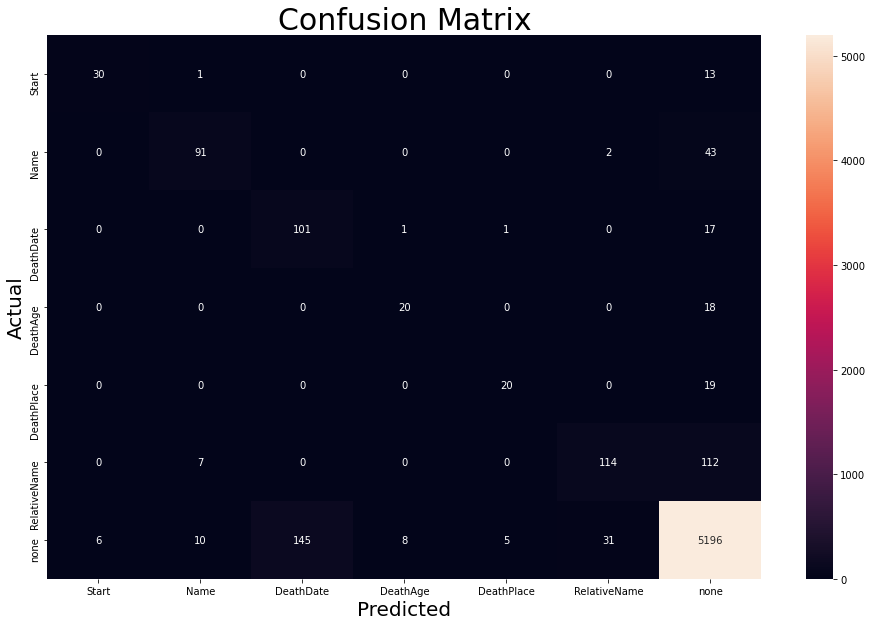

In [191]:
encoder.idx_to_entity(1)
class_labels = [encoder.idx_to_entity(i) for i in range(encoder.num_classes())]

plt.figure(figsize = (16, 10))
sns.heatmap(matrix, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix', fontdict={'fontsize': 30})
plt.xlabel('Predicted', fontdict={'fontsize': 20})
plt.ylabel('Actual', fontdict={'fontsize': 20})

In [192]:
print('Accuracies Based on Category:')

sums = np.sum(matrix, axis=0)

for i in range(len(matrix[0])):
  print('- ', encoder.idx_to_entity(i) + ' ({}): '.format(i), matrix[i][i] / sums[i])

Accuracies Based on Category:
-  Start (0):  0.8333333333333334
-  Name (1):  0.8348623853211009
-  DeathDate (2):  0.4105691056910569
-  DeathAge (3):  0.6896551724137931
-  DeathPlace (4):  0.7692307692307693
-  RelativeName (5):  0.7755102040816326
-  none (6):  0.9590254706533776
